<a href="https://colab.research.google.com/github/penguin1109/BOAZ_BASE_2021/blob/main/CVStacking_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
%matplotlib inline

### Load Data

In [ ]:
root_dir = '/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/Final_Solution_Folders/DATA'
test = pd.read_csv(root_dir + '/test.csv')
sales = pd.read_csv(root_dir + '/sales_train.csv')
shops = pd.read_csv(root_dir + '/shops.csv')
items = pd.read_csv(root_dir + '/items.csv')
item_cats = pd.read_csv(root_dir + '/item_categories.csv')

### TRAINING

In [ ]:
root_dir = '/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/Final_Solution_Folders/DATA'
df = pd.read_csv(root_dir + '/FINALDATASET.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'city_code', 'city_coord_1', 'city_coord_2', 'country_part',
       'item_category_common', 'item_category_code', 'weekend_count',
       'days_in_month', 'item_first_interaction', 'shop_item_sold_before',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1',
       'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3',
       'new_item_cat_avg_lag_1', 'new_item_cat_avg_lag_2',
       'new_item_cat_avg_lag_3', 'new_item_shop_cat_avg_lag_1',
       'new_item_shop_cat_avg_lag_2', 'new_item_shop_cat_avg_lag_3',
       'item_cnt_month_lag_1_adv', 'item_cnt_month_lag_2_adv',
 

In [ ]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
feature_name = X_train.columns.to_list()

del df # 메모리 절약을 위해

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape

((9481110, 38), (9481110,), (238172, 38), (238172,), (214200, 38))

In [ ]:
new_x_train, new_y_train = pd.concat([X_train, X_valid], axis = 0), pd.concat([Y_train, Y_valid], axis = 0)
new_x_test = X_test

In [ ]:
new_x_train.shape, new_y_train.shape

((9719282, 38), (9719282,))

- stacking ensenble을 위해서 new_x_train과 new_x_test를 만들었다.

### MODEL 01(XGBoost)

In [ ]:
model01 = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.05,
    seed=42)

In [ ]:
model01.fit(X_train[feature_name], Y_train, eval_metric = ['rmse'], 
            eval_set=[(X_valid[feature_name], Y_valid)], early_stopping_rounds=50, 
            verbose = 20)

[02:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:34:45] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.11579
Will train until validation_0-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:0.910311
[40]	validation_0-rmse:0.915523
[60]	validation_0-rmse:0.913332
Stopping. Best iteration:
[26]	validation_0-rmse:0.908557



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.05, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [ ]:
model01_Train = model01.predict(X_train[feature_name]).clip(0, 20)
pd.DataFrame(model01_Train, columns = ['item_cnt_month']).to_csv(root_dir + '/xgboost01/Train.csv', index = False)

In [ ]:
model01_Valid = model01.predict(X_valid[feature_name]).clip(0, 20)
pd.DataFrame(model01_Valid, columns = ['item_cnt_month']).to_csv(root_dir + '/xgboost01/Valid.csv', index = False)

In [ ]:
model01_Test = model01.predict(X_test[feature_name]).clip(0, 20)
pd.DataFrame(model01_Test, columns = ['item_cnt_month']).to_csv(root_dir + '/xgboost01/Test.csv', index = False)

### MODEL 02 (LightGBM)

In [ ]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 8 - 1,
    'learning_rate': 0.0025,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 7,
    'seed': 1,
    'verbose': 1
}
feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

In [ ]:
evals_result = {}
model02 = lgb.train(
        params, 
        lgb_train, 
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=200, 
        evals_result = evals_result,
        early_stopping_rounds = 150)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 1.02227	valid_1's rmse: 0.99519
[400]	training's rmse: 0.928228	valid_1's rmse: 0.935216
[600]	training's rmse: 0.880963	valid_1's rmse: 0.910507
[800]	training's rmse: 0.853554	valid_1's rmse: 0.899628
[1000]	training's rmse: 0.835615	valid_1's rmse: 0.894456
[1200]	training's rmse: 0.821391	valid_1's rmse: 0.892596
[1400]	training's rmse: 0.810205	valid_1's rmse: 0.891739
[1600]	training's rmse: 0.801344	valid_1's rmse: 0.891308
[1800]	training's rmse: 0.79391	valid_1's rmse: 0.890651
[2000]	training's rmse: 0.787677	valid_1's rmse: 0.889765
[2200]	training's rmse: 0.781857	valid_1's rmse: 0.889338
[2400]	training's rmse: 0.777012	valid_1's rmse: 0.889081
[2600]	training's rmse: 0.772549	valid_1's rmse: 0.888796
[2800]	training's rmse: 0.768747	valid_1's rmse: 0.888298
[3000]	training's rmse: 0.765241	valid_1's rmse: 0.888057
Did not meet early stopping. Best iteration is:
[3000]	training's rmse: 0.

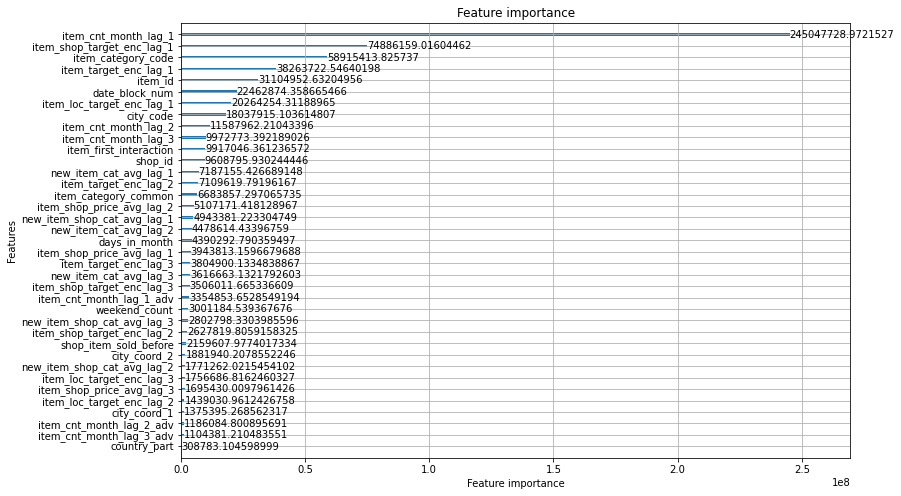

In [ ]:
lgb.plot_importance(
    model02, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
model02_Train = model02.predict(X_train[feature_name]).clip(0, 20)

In [ ]:
pd.DataFrame(model02_Train, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm01/Train.csv', index = False)

In [ ]:
model02_Valid = model02.predict(X_valid[feature_name]).clip(0, 20)
pd.DataFrame(model02_Valid, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm01/Valid.csv', index = False)

In [ ]:
model02_Test = model02.predict(X_test[feature_name]).clip(0, 20)
pd.DataFrame(model02_Test, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm01/Test.csv', index = False)

In [ ]:
lightSub = pd.DataFrame([int(i) for i in range(len(model02_Test))], columns = ['ID'])
lightSub['item_cnt_month'] = model02_Test
lightSub.head(10).T

,0,1,2,3,4,5,6,7,8,9
ID,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.00000,9.000000
item_cnt_month,0.330188,0.404692,0.828781,0.427118,2.131196,0.485417,0.808651,0.117921,0.59041,0.633356


In [ ]:
Y_train[:10]

0
1122795    3.0
1122796    3.0
1122797    3.0
1122798    1.0
1122799    1.0
1122800    1.0
1122801    5.0
1122802    2.0
1122803    7.0
1122804    2.0
Name: item_cnt_month, dtype: float64

In [ ]:
lightSub = pd.DataFrame([int(i) for i in range(len(model02_Test))], columns = ['ID'])
lightSub['item_cnt_month'] = model02_Test
lightSub.head(5)

In [ ]:
lightSub.to_csv(root_dir + '/210311_FIN.csv', index = False)

### MODEL 03 (LightGBM)

In [ ]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 8 - 1,
    'learning_rate': 0.003,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 7,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
model03 = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=200, 
        evals_result = evals_result,
        early_stopping_rounds = 150)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 0.997703	valid_1's rmse: 0.978357
[400]	training's rmse: 0.905698	valid_1's rmse: 0.923059
[600]	training's rmse: 0.863152	valid_1's rmse: 0.903515
[800]	training's rmse: 0.8384	valid_1's rmse: 0.896472
[1000]	training's rmse: 0.821574	valid_1's rmse: 0.893313
[1200]	training's rmse: 0.808323	valid_1's rmse: 0.892213
Early stopping, best iteration is:
[1248]	training's rmse: 0.805668	valid_1's rmse: 0.892


In [ ]:
model03_Train = model03.predict(X_train[feature_name]).clip(0, 20)
pd.DataFrame(model03_Train, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm02/Train.csv', index = False)

In [ ]:
model03_Valid = model03.predict(X_valid[feature_name]).clip(0, 20)
pd.DataFrame(model03_Valid, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm02/Valid.csv', index = False)

In [ ]:
model03_Test = model03.predict(X_test[feature_name]).clip(0, 20)
pd.DataFrame(model03_Test, columns = ['item_cnt_month']).to_csv(root_dir + '/lightgbm02/Test.csv', index = False)

### FINAL TRAIN & TEST DATA for DNN

In [ ]:
FIN_train = pd.DataFrame(model01_Train, columns = ['model01'])
FIN_train['model02'] = model02_Train
FIN_train['model03'] = model03_Train

In [ ]:
FIN_train.head(5)

,model01,model02,model03
0,0.795926,0.749548,0.854349
1,2.960746,2.986387,2.841715
2,0.434173,0.099821,0.293082
3,0.312419,0.380552,0.384256
4,0.675998,0.556004,0.735100


In [ ]:
FIN_valid = pd.DataFrame(model01_Valid, columns = ['model01'])
FIN_valid['model02'] = model02_Valid
FIN_valid['model03'] = model03_Valid

In [ ]:
FIN_valid.head(5)

,model01,model02,model03
0,0.464895,0.329557,0.479308
1,0.412270,0.333852,0.280101
2,1.124197,0.764439,1.099375
3,0.445630,0.372001,0.498941
4,2.956417,2.307134,3.202197


In [ ]:
FIN_test = pd.DataFrame(model01_Test, columns = ['model01'])
FIN_test['model02'] = model02_Test
FIN_test['model03'] = model03_Test

In [ ]:
FIN_train.to_csv(root_dir + '/FIN_train.csv')
FIN_valid.to_csv(root_dir + '/FIN_valid.csv')
FIN_test.to_csv(root_dir + '/FIN_test.csv')

### FINAL STACKING TRAINING 01
#### Stacking Ensemble


1.   마지막 meta model로 다항회귀를 이용할 생각이다.
2.   3개의 데이터가 input이기 때문에 Polynomial Features를 이용해서 degree = 5로 설정해 회귀를 진행해볼 예정이다.
  - degree를 설정하는 부분에서 주의를 해 주어야 하는데, 이는 degree가 너무 크다면 과대적합될 위험이, 너무 작다면 과소 적합될 위험이 존재하기 때문이다.
3.   이는 나 또한 착각했던 부분이지만, 사실 다항회귀 또한 선형 회귀이며, sklearn의 PolynomialFeatures class는 Degree Parameter을 이용해서 입력받은 단항식 feature을 degree에 해당하는 다항식 feature로 바꾸어 준다.




In [ ]:
root_dir = '/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/Final_Solution_Folders/DATA'

In [ ]:
model01_Train, model02_Train, model03_Train = pd.read_csv(root_dir + '/xgboost01/Train.csv', index_col=0), pd.read_csv(root_dir+'/lightgbm01/Train.csv', index_col = 0), pd.read_csv(root_dir + '/lightgbm02/Train.csv', index_col = 0)
model01_Test, model02_Test, model03_Test = pd.read_csv(root_dir + '/xgboost01/Test.csv', index_col = 0), pd.read_csv(root_dir + '/lightgbm01/Test.csv', index_col = 0), pd.read_csv(root_dir + '/lightgbm02/Test.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
model01_Valid, model02_Valid, model03_Valid = pd.read_csv(root_dir + '/xgboost01/Valid.csv', index_col = 0), pd.read_csv(root_dir + '/lightgbm02/Valid.csv', index_col = 0), pd.read_csv(root_dir + '/lightgbm02/Valid.csv')

- 최종 모델에 학습 데이터를 넣기 위해서 개별 알고리즘으로부터 예측된 예측값을 column level로 옆으로 붙여 feature값으로 만들어 최종 model의 학습 데이터로 사용을 하였다.
- 반환된 예측 데이터 세트는 1차원의 ndarray이기 때문에 먼저 반환된 예측 결과를 행 형태로 붙이고 numpy의 transpose -> 이렇게 하면 shape가 (a,b)->(b,a)로 바뀐다. 
- 이렇게 행과 열의 위치를 바꾼 데이터를 사용하였다.

In [ ]:
Stack_final_x_train = np.transpose(np.array([model01_Train, model02_Train, model03_Train]))
Stack_final_x_test = np.transpose(np.array([model01_Test, model02_Test, model03_Test]))

In [ ]:
Stack_final_x_valid = np.transpose(np.array([model01_Valid.index, model02_Valid.index, model03_Valid]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
Stack_final_x_test.shape

(214200, 3)

In [ ]:
Stack_final_x_train.shape

(9481110, 3)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

polynomial_features = PolynomialFeatures(degree = 5, include_bias = False)
linear_regression = LinearRegression()

pipeline = Pipeline([("polynomial_features", polynomial_features), 
                     ("linear_regression", linear_regression)])

pipeline.fit(Stack_final_x_train, Y_train)

In [ ]:
FIN_predict = pipeline.predict(Stack_final_x_test)

In [ ]:
FIN_predict

array([0.32204784, 0.31674966, 0.69613991, ..., 0.05204083, 0.02857714,
       0.04404718])

### FINAL STACKING TRAINING 02
#### Stacking Ensemble (CV Fold Data)
1. CV 세트 기반의 stacking model은 overfitting을 개선하기 위해서 최종 메타 모델을 위한 데이터를 만들 때 교차 검증 기반으로 예측된 데이터를 이용한다.
2. 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용, 테스트용 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행하게 된다.


#### LAST METHA MODEL FOR TRAINING


1.   Logistic Regression을 마지막 회귀 모델로 사용할 예정이다.
2.   스태킹에 사용될 개별 모델은 XGBoost1개와 LIghtGBM 2개이다.  
3.   이들 모델의 예측 결과를 합한 데이터 세트로 학습/예측을 하는 최종 모델은 Logistic Regression이다.





In [ ]:
from sklearn.model_selction import KFold

def get_stacking_base_datasets(model, x_train, y_train, x_test, n_folds):
  kf = KFold(nOsplits = n_folds, shuffle = True, random_state = 42)
  train_fold_predict = np.zeros((x_train.shape[0], 1))
  test_predict = np.zeros((x_test.shape[0], n_folds))
  print(model.__class__.__name__, 'Model Started')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(x_train)):
    print('\t Fold Set : ', folder_counter, 'Start')
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_va = x_train[valid_index]

    if model == model01:
      model01.fit(X_train[feature_name], Y_train, eval_metric = ['rmse'], 
            eval_set=[(X_valid[feature_name], Y_valid)], early_stopping_rounds=50, 
            verbose = 20)
    elif model == model02:
      evals_result = {}
      model02 = lgb.train(
        params, 
        lgb_train, 
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=200, 
        evals_result = evals_result,
        early_stopping_rounds = 150)


      

### FINAL DNN MODEL

In [ ]:
import pandas as pd
root_dir = '/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/Final_Solution_Folders/DATA'
dnn_train = pd.read_csv(root_dir + '/dnn_train.csv', index_col = 0)
dnn_test = pd.read_csv(root_dir + '/dnn_test.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
dnn_train.shape

(9481110, 3)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

In [ ]:
batch_size = 100
initializer = tf.keras.initializers.HeNormal()

DNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape = [3],activation = 'relu', kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation = 'relu', kernel_initializer = initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

DNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                128       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
_________________________________________________________________
batch_normalization_4 (Batch (None, 3)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 371
Trainable params: 301
Non-trainable params: 70
_______________________________________________________

- 미리 xgboost모델을 이용해서 dnn_train데이터를 이용해서 학습을 시키고
- plot_importance함수를 이용해서 각각이 모델의 중요도를 파악한 뒤에
- 해당 값을 처음부터 DNN모델에 반영이 되도록 사용자 정의 layer을 만들어서 학습시킬 생각이다.

#### Optimizer
- 의외로 Adam을 이용할 때 보다 rmsProp을 이용하고 애초에 주어지는 1e-3이라는 학습률을 유지했을 때 validation_loss와 validation_accuracy가 더 좋았던 것 같다.
- learning_rate는 1e-3에서 1e-5가 이상적인 값이다.
- Adam의 경우에는 max(0, x)라는 함수를 이용해서 비선형성을 부과하기 때문에 음수가 나오지만 않는다면 크게 문제가 되는 부분이 없다고 한다.

#### Weight Initializer
- LU계열의 Relu activation function을 사용하기 때문에 HeNormalization을 사용하였다.

#### Batch Normalization
- 논문에 의하면 비선형 함수 이전에 넣는것이 좋다고 한다.(미미한 차이지만)
- 그리고 데이터셋과 배치 사이즈가 클수록 효과를 보인다고 한다.
- 비선형 함수 이전에 넣기 위해서는 반드시 비선형 함수를 따로 추가해야 한다.
```py
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.activation.Relu)
```
이런 식으로 추가해 주는 것이다.


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0)
DNN_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['accuracy','mae', 'mse'])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
history = DNN_model.fit(Stack_final_x_train, Y_train, epochs = 30, validation_data = (Stack_final_x_valid, Y_valid),
                        batch_size = batch_size, callbacks = callback, verbose = 2, shuffle = True)

Epoch 1/30
94812/94812 - 131s - loss: 0.7228 - accuracy: 0.8264 - mae: 0.3442 - mse: 0.7228 - val_loss: 0.8981 - val_accuracy: 0.8545 - val_mae: 0.2770 - val_mse: 0.8981
Epoch 2/30
94812/94812 - 131s - loss: 0.7124 - accuracy: 0.8265 - mae: 0.3435 - mse: 0.7124 - val_loss: 0.8769 - val_accuracy: 0.8569 - val_mae: 0.2985 - val_mse: 0.8769
Epoch 3/30
94812/94812 - 131s - loss: 0.7164 - accuracy: 0.8261 - mae: 0.3443 - mse: 0.7164 - val_loss: 0.9112 - val_accuracy: 0.8564 - val_mae: 0.3133 - val_mse: 0.9112
Epoch 4/30
94812/94812 - 128s - loss: 0.7137 - accuracy: 0.8263 - mae: 0.3442 - mse: 0.7137 - val_loss: 0.8532 - val_accuracy: 0.8499 - val_mae: 0.2958 - val_mse: 0.8532
Epoch 5/30
94812/94812 - 134s - loss: 0.7115 - accuracy: 0.8262 - mae: 0.3438 - mse: 0.7115 - val_loss: 1.6257 - val_accuracy: 0.8588 - val_mae: 0.3203 - val_mse: 1.6257
Epoch 6/30
94812/94812 - 131s - loss: 0.7104 - accuracy: 0.8264 - mae: 0.3431 - mse: 0.7104 - val_loss: 1.2666 - val_accuracy: 0.8554 - val_mae: 0.310

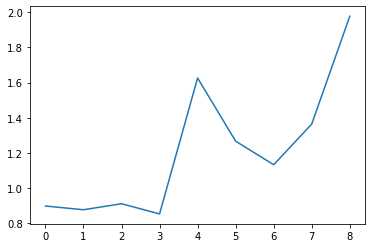

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
FIN_predict = DNN_model.predict(Stack_final_x_test)

In [ ]:
FIN_predict

array([[0.2554415 ],
       [0.24563962],
       [0.5018549 ],
       ...,
       [0.1066395 ],
       [0.09337652],
       [0.1011318 ]], dtype=float32)

### Make Submission File

In [ ]:
SUBMIT = pd.DataFrame([int(i) for i in range(len(FIN_predict))], columns = ['ID'])
SUBMIT['item_cnt_month'] = FIN_predict
SUBMIT.head(5)

,ID,item_cnt_month
0,0,0.255441
1,1,0.245640
2,2,0.501855
3,3,0.298129
4,4,1.478706


In [ ]:
SUBMIT.to_csv(root_dir + '/Sub031102.csv', index = False)